In [186]:
import pandas as pd                 # pandas is a dataframe library
import matplotlib.pyplot as plt     # matplotlib.pyplot plots data
import numpy as np                  # numpy provides N-dim object support

# do ploting inline instead of in a separate window
%matplotlib inline

In [187]:
#READ AND PARSE AIRLINE FILE
airline_tweets = pd.read_csv('airline_tweets.csv', usecols=['airline_sentiment','tweet_coord'],encoding='utf-8')
airline_tweets=airline_tweets.dropna()
airline_tweets=airline_tweets.loc[airline_tweets['tweet_coord'] != '[0.0, 0.0]']
sentiment_map = { 'negative' : 0,'neutral' :1,'positive' : 2}
airline_tweets['airline_sentiment'] = airline_tweets['airline_sentiment'].map(sentiment_map)
airline_tweets['tweet_coord'].replace(regex=True,inplace=True,to_replace=r'\[',value=r'')
airline_tweets['tweet_coord'].replace(regex=True,inplace=True,to_replace=r'\]',value=r'')
airline_tweets = airline_tweets.reset_index(drop=True)

split_c = airline_tweets['tweet_coord'].apply(lambda x: x.split(','))
airline_tweets['latitude'] = split_c.apply(lambda x: float(x[0]))
airline_tweets['longitude'] = split_c.apply(lambda x: float(x[1]))
airline_tweets.drop(['tweet_coord'],axis=1)

#READ AND PARSE CITIES
cities = pd.read_csv( "cities.csv", delimiter="," ,header='infer',usecols=['name','latitude','longitude'],encoding='utf-8')
cities=cities.dropna()
cities['city_coord']= cities[['latitude','longitude']].values.tolist()

In [188]:
airline_tweets[0:5]

,airline_sentiment,tweet_coord,latitude,longitude
0,2,"40.74804263, -73.99295302",40.748043,-73.992953
1,0,"42.361016, -71.02000488",42.361016,-71.020005
2,1,"33.94540417, -118.4062472",33.945404,-118.406247
3,0,"33.94209449, -118.40410103",33.942094,-118.404101
4,2,"33.2145038, -96.9321504",33.214504,-96.932150


In [189]:
cities[0:5]

,name,latitude,longitude,city_coord
0,les Escaldes,42.50729,1.53414,"[42.507290000000005, 1.53414]"
1,Andorra la Vella,42.50779,1.52109,"[42.50779, 1.52109]"
2,Umm al Qaywayn,25.56473,55.55517,"[25.564729999999997, 55.55517]"
3,Ras al-Khaimah,25.78953,55.94320,"[25.78953, 55.9432]"
4,Khawr Fakkān,25.33132,56.34199,"[25.33132, 56.34199]"


In [190]:
# find the nearest city to the tweet coorinates usin ckdtree(nearest neighbour) and query(Euclidean)
from scipy.spatial import cKDTree

def closest_pts(setA_lat, setA_lng, setB_lat, setB_lng):
    a_x = setA_lat.values
    a_y = setA_lng.values
    b_x = setB_lat.values
    b_y = setB_lng.values
    #print(a_x[0:5])
    a = np.c_[a_x, a_y]
    #print(a)
    b = np.c_[b_x, b_y]
    indx = cKDTree(b).query(a,k=1,p=2)[1]
    #print(indx)
    return pd.Series(b_x[indx]), pd.Series(b_y[indx]),pd.Series(cities['name'][indx])

In [191]:
setA_lat = airline_tweets['latitude']
setA_lng =  airline_tweets['longitude']

setB_lat = cities['latitude']
setB_lng =  cities['longitude']

In [192]:
c_x,c_y,c_n = closest_pts(setA_lat, setA_lng, setB_lat, setB_lng)

In [193]:
c_n = c_n.reset_index(drop=True)
c_n[0:5]

0    New York City
1          Chelsea
2       El Segundo
3       El Segundo
4           Frisco
Name: name, dtype: object

In [194]:
airline_tweets['nearest_latitude'] = c_x
airline_tweets['nearest_longitude'] = c_y
airline_tweets['nearest_city'] =c_n

In [195]:
airline_tweets[0:10]

,airline_sentiment,tweet_coord,latitude,longitude,nearest_latitude,nearest_longitude,nearest_city
0,2,"40.74804263, -73.99295302",40.748043,-73.992953,40.71427,-74.00597,New York City
1,0,"42.361016, -71.02000488",42.361016,-71.020005,42.39176,-71.03283,Chelsea
2,1,"33.94540417, -118.4062472",33.945404,-118.406247,33.91918,-118.41647,El Segundo
3,0,"33.94209449, -118.40410103",33.942094,-118.404101,33.91918,-118.41647,El Segundo
4,2,"33.2145038, -96.9321504",33.214504,-96.932150,33.15067,-96.82361,Frisco
5,1,"34.0219817, -118.38591198",34.021982,-118.385912,34.02112,-118.39647,Culver City
6,1,"33.57963333, -117.73024772",33.579633,-117.730248,33.56504,-117.72712,Aliso Viejo
7,0,"40.6413712, -73.78311558",40.641371,-73.783116,40.66312,-73.76221,Springfield Gardens
8,2,"36.08457854, -115.13780136",36.084579,-115.137801,36.09719,-115.14666,Paradise
9,1,"37.79374402, -122.39327564",37.793744,-122.393276,37.77493,-122.41942,San Francisco


In [213]:
feature_df = airline_tweets[['nearest_city']]

In [214]:
label_df = airline_tweets['airline_sentiment']

In [215]:
print(type(feature_df))
print(type(label_df))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [223]:
# feature encoding
features = pd.get_dummies(feature_df, columns=["nearest_city"])
features[0:5]

,nearest_city_Addison,nearest_city_Aldine,nearest_city_Aliso Viejo,nearest_city_Allen,nearest_city_American Fork,nearest_city_Anaheim,nearest_city_Angeles City,nearest_city_Annapolis,nearest_city_Arbutus,nearest_city_Ashford,...,nearest_city_Whitestone,nearest_city_Williamsport,nearest_city_Willow Grove,nearest_city_Windsor,nearest_city_Winnipeg,nearest_city_Winter Park,nearest_city_Wolverhampton,nearest_city_Woodstock,nearest_city_Xiuying,nearest_city_Zionsville
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [268]:
col = features.columns.values  # use this if u have to get feature names
feature_names = pd.Series(col)
type(feature_names)

list

In [225]:
# label encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(label_df.values)
print(list(le.classes_))
labels = le.transform(label_df)
labels[0:5]

[0, 1, 2]


array([2, 0, 1, 0, 2])

In [226]:
type(labels)

numpy.ndarray

In [227]:
label_df.values[0:5]

array([2, 0, 1, 0, 2])

In [228]:
# luigi
features['labels'] = labels

In [229]:
features[0:5]  # save this to csv

,nearest_city_Addison,nearest_city_Aldine,nearest_city_Aliso Viejo,nearest_city_Allen,nearest_city_American Fork,nearest_city_Anaheim,nearest_city_Angeles City,nearest_city_Annapolis,nearest_city_Arbutus,nearest_city_Ashford,...,nearest_city_Williamsport,nearest_city_Willow Grove,nearest_city_Windsor,nearest_city_Winnipeg,nearest_city_Winter Park,nearest_city_Wolverhampton,nearest_city_Woodstock,nearest_city_Xiuying,nearest_city_Zionsville,labels
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [120]:
labels = features['labels']
labels = np.array(labels)
features= features.drop(['labels'],axis=1)

In [121]:
features[0:5]

,nearest_city_Addison,nearest_city_Aldine,nearest_city_Aliso Viejo,nearest_city_Allen,nearest_city_American Fork,nearest_city_Anaheim,nearest_city_Angeles City,nearest_city_Annapolis,nearest_city_Arbutus,nearest_city_Ashford,...,nearest_city_Whitestone,nearest_city_Williamsport,nearest_city_Willow Grove,nearest_city_Windsor,nearest_city_Winnipeg,nearest_city_Winter Park,nearest_city_Wolverhampton,nearest_city_Woodstock,nearest_city_Xiuying,nearest_city_Zionsville
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
# remove if does not work
#labels = label_df.values has same effect as above transformation

In [230]:
print(features.shape)
print(labels.shape)

(855, 292)
(855,)


In [231]:
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size = 0.40, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)

In [232]:
print(type(X_train),X_train.shape)
print(type(y_train),y_train.shape)
print(type(X_test),X_test.shape)
print(type(y_test),y_test.shape)

<class 'numpy.ndarray'> (513, 292)
<class 'numpy.ndarray'> (513,)
<class 'numpy.ndarray'> (342, 292)
<class 'numpy.ndarray'> (342,)


## Fitting GaussianNB

In [238]:
from sklearn.naive_bayes import GaussianNB
# create Gaussian Naive Bayes model object and train it with the data
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB(priors=None)

In [298]:
import pickle
from sklearn import metrics

# save the classifier
# save the model to disk
filename = 'finalized_model.gnb'
pickle.dump(nb_model, open(filename, 'wb'))   

# load the model from disk
nb_model = pickle.load(open(filename, 'rb'))
ModelScore = nb_model.score(X_test, y_test)
print(ModelScore)

0.973684210526


In [299]:
# predict values using the training data
nb_predict_class = nb_model.predict(X_test)
# Accuracy
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, nb_predict_class)))
print()

Accuracy: 0.9737



In [245]:
nb_predict_class[0:5]

array([0, 1, 0, 0, 2])

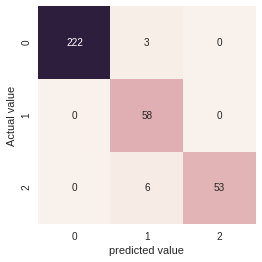

In [300]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_test,nb_predict_class)
sns.heatmap(mat,square=True,annot=True,fmt='g',cbar=False)
#plt(figsize=(5,5))
plt.xlabel('predicted value')
plt.ylabel('Actual value')

In [247]:
# Although the accuracy is low, this fits the data really well.

In [248]:
from sklearn.model_selection import cross_val_score
cross_val_score(nb_model,X_test, y_test)

array([ 0.95652174,  0.92982456,  1.        ])

In [251]:
probabilities = nb_model.predict_proba(X_test)

In [252]:
nb_model.classes_

array([0, 1, 2])

In [253]:
probabilities[0:50]

array([[  1.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   1.00000000e+000,   0.00000000e+000],
       [  1.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  1.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   1.00000000e+000],
       [  1.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   1.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   1.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   1.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   1.00000000e+000],
       [  1.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   1.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   1.00000000e+000],
       [  1.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  1.00000000e+000,   0.00000000e+000,   0.00000000e+000],
       [  

In [147]:
probabilities.shape

(342, 3)

In [148]:
#delete me
nb_model.predict_proba?

In [254]:
classes = nb_model.classes_

In [255]:
X_test[0:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 2]])

In [256]:
predict = nb_model.predict(X_test)

In [257]:
predict[0:5]

array([0, 1, 0, 0, 2])

TypeError: 'feature_name' is an invalid keyword argument for this function

In [269]:
len(feature_names)

291

In [270]:
len(feature_names)

291

In [271]:
type(feature_names)

list

In [272]:
type(probabilities)

numpy.ndarray

In [273]:
probabilities.shape

(342, 3)

In [158]:
# delete me


In [274]:
probabilities_df = pd.DataFrame(probabilities,columns=['negative','neutral','positive'])

In [275]:
probabilities_df[0:5]

,negative,neutral,positive
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


In [276]:
feature_name_series = pd.Series(feature_names)

In [277]:
probabilities_df['cities'] = feature_name_series

In [278]:
probabilities_df[0:5]

,negative,neutral,positive,cities
0,1.0,0.0,0.0,nearest_city_Addison
1,0.0,1.0,0.0,nearest_city_Aldine
2,1.0,0.0,0.0,nearest_city_Aliso Viejo
3,1.0,0.0,0.0,nearest_city_Allen
4,0.0,0.0,1.0,nearest_city_American Fork


In [279]:
city_probability = probabilities_df[['cities','negative','neutral','positive']]

In [280]:
city_probability[0:5]

,cities,negative,neutral,positive
0,nearest_city_Addison,1.0,0.0,0.0
1,nearest_city_Aldine,0.0,1.0,0.0
2,nearest_city_Aliso Viejo,1.0,0.0,0.0
3,nearest_city_Allen,1.0,0.0,0.0
4,nearest_city_American Fork,0.0,0.0,1.0


In [281]:
type(predict)

numpy.ndarray

In [282]:
predictions = pd.Series(predict)
predictions[0:5]

0    0
1    1
2    0
3    0
4    2
dtype: int64

In [283]:
city_probability['model_predictions'] = predictions

/home/vijay/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [284]:
city_probability[0:10]

,cities,negative,neutral,positive,model_predictions
0,nearest_city_Addison,1.0,0.0,0.0,0
1,nearest_city_Aldine,0.0,1.0,0.0,1
2,nearest_city_Aliso Viejo,1.0,0.0,0.0,0
3,nearest_city_Allen,1.0,0.0,0.0,0
4,nearest_city_American Fork,0.0,0.0,1.0,2
5,nearest_city_Anaheim,1.0,0.0,0.0,0
6,nearest_city_Angeles City,0.0,1.0,0.0,1
7,nearest_city_Annapolis,0.0,0.0,1.0,2
8,nearest_city_Arbutus,0.0,0.0,1.0,2
9,nearest_city_Ashford,0.0,0.0,1.0,2


In [285]:
y_test[0:10]

array([0, 1, 0, 0, 2, 0, 1, 2, 2, 2])

In [286]:
sentiment_map = { 0:'negative',1:'neutral',2:'positive'}
city_probability['sentiment_prediction'] = city_probability['model_predictions'].map(sentiment_map)

/home/vijay/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [287]:
city_probability[0:10]

,cities,negative,neutral,positive,model_predictions,sentiment_prediction
0,nearest_city_Addison,1.0,0.0,0.0,0,negative
1,nearest_city_Aldine,0.0,1.0,0.0,1,neutral
2,nearest_city_Aliso Viejo,1.0,0.0,0.0,0,negative
3,nearest_city_Allen,1.0,0.0,0.0,0,negative
4,nearest_city_American Fork,0.0,0.0,1.0,2,positive
5,nearest_city_Anaheim,1.0,0.0,0.0,0,negative
6,nearest_city_Angeles City,0.0,1.0,0.0,1,neutral
7,nearest_city_Annapolis,0.0,0.0,1.0,2,positive
8,nearest_city_Arbutus,0.0,0.0,1.0,2,positive
9,nearest_city_Ashford,0.0,0.0,1.0,2,positive


In [290]:
# save all cities with their probabilitiy classes, model prediction and sentiment prediction
city_probability.to_csv('city_probability.csv')
# save a sorted list of cities by the predicted positive sentiment score to the output file
predicted_positive = city_probability[city_probability['model_predictions'] == 2]
sorted_predicted_positive = predicted_positive.sort_values(['positive'], ascending=[False])
sorted_predicted_positive.to_csv('sorted_predicted_positive.csv')

In [291]:
sorted_predicted_positive[0:5]

,cities,negative,neutral,positive,model_predictions,sentiment_prediction
4,nearest_city_American Fork,0.0,0.0,1.0,2,positive
151,nearest_city_Mariners Harbor,0.0,0.0,1.0,2,positive
152,nearest_city_Marlborough,0.0,0.0,1.0,2,positive
157,nearest_city_Midland,0.0,0.0,1.0,2,positive
159,nearest_city_Milton,0.0,0.0,1.0,2,positive


In [292]:
#sorted_predicted_positive['positive'].astype('float')

In [293]:
# validate the column mapping and matched predictions
airline_tweets[airline_tweets['nearest_city'] =='American Fork']

,airline_sentiment,tweet_coord,latitude,longitude,nearest_latitude,nearest_longitude,nearest_city
297,2,"40.35805521, -111.78241283",40.358055,-111.782413,40.3769,-111.79576,American Fork


In [294]:
airline_tweets[airline_tweets['nearest_city'] =='Aldine'][:1]

,airline_sentiment,tweet_coord,latitude,longitude,nearest_latitude,nearest_longitude,nearest_city
31,1,"29.98386923, -95.33729612",29.983869,-95.337296,29.93245,-95.38021,Aldine


In [297]:
# use log probabilities to help sort better
log_probabilities = nb_model.predict_log_proba(X_test)
print(log_probabilities.shape)
log_probabilities_df = pd.DataFrame(log_probabilities,columns=['negative','neutral','positive'])
feature_name_series = pd.Series(feature_names)
log_probabilities_df['cities'] = feature_name_series
log_city_probability = log_probabilities_df[['cities','negative','neutral','positive']]
log_city_probability['model_predictions'] = predictions
log_city_probability[0:10]

(342, 3)


/home/vijay/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,cities,negative,neutral,positive,model_predictions
0,nearest_city_Addison,0.000000e+00,-8.267532e+08,-3.307015e+09,0
1,nearest_city_Aldine,-8.267546e+08,0.000000e+00,-8.267540e+08,1
2,nearest_city_Aliso Viejo,0.000000e+00,-8.267532e+08,-3.307015e+09,0
3,nearest_city_Allen,0.000000e+00,-1.653507e+09,-4.133769e+09,0
4,nearest_city_American Fork,-3.307016e+09,-1.653508e+09,0.000000e+00,2
5,nearest_city_Anaheim,0.000000e+00,-8.267532e+08,-4.133769e+09,0
6,nearest_city_Angeles City,-8.267546e+08,0.000000e+00,-8.267540e+08,1
7,nearest_city_Annapolis,-3.307016e+09,-8.267538e+08,0.000000e+00,2
8,nearest_city_Arbutus,-3.307016e+09,-8.267538e+08,0.000000e+00,2
9,nearest_city_Ashford,-3.307016e+09,-8.267538e+08,0.000000e+00,2


In [296]:
log_city_probability[log_city_probability['model_predictions']==2]

,cities,negative,neutral,positive,model_predictions
4,nearest_city_American Fork,-3.307016e+09,-1.653508e+09,0.0,2
7,nearest_city_Annapolis,-3.307016e+09,-8.267538e+08,0.0,2
8,nearest_city_Arbutus,-3.307016e+09,-8.267538e+08,0.0,2
9,nearest_city_Ashford,-3.307016e+09,-8.267538e+08,0.0,2
12,nearest_city_Atascocita,-2.480262e+09,-8.267538e+08,0.0,2
26,nearest_city_Boise,-3.307016e+09,-1.653508e+09,0.0,2
34,nearest_city_Brighton,-2.480262e+09,-8.267538e+08,0.0,2
39,nearest_city_Bushwick,-3.307016e+09,-8.267538e+08,0.0,2
43,nearest_city_Canary Wharf,-3.307016e+09,-1.653508e+09,0.0,2
46,nearest_city_Carolina,-3.307016e+09,-8.267538e+08,0.0,2


In [310]:
# TRY LOgistic again

In [311]:
from sklearn.linear_model import LogisticRegression

lr_model =LogisticRegression(C=0.7, random_state=42)
lr_model.fit(X_train, y_train)

# training metrics
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, lr_predict_class)))
print(metrics.confusion_matrix(y_test, lr_predict_class, labels=[1, 0]) )
print("")
print("Classification Report")
print(metrics.classification_report(y_test, lr_predict_class, labels=[1,0]))

Accuracy: 0.8509
[[  7   0]
 [  0 225]]

Classification Report
             precision    recall  f1-score   support

          1       1.00      0.12      0.22        58
          0       1.00      1.00      1.00       225

avg / total       1.00      0.82      0.84       283



In [313]:
import pickle
from sklearn import metrics

# save the classifier
# save the model to disk
filename = 'finalized_model.lr'
pickle.dump(lr_model, open(filename, 'wb'))   

# load the model from disk
lr_model = pickle.load(open(filename, 'rb'))
ModelScore = lr_model.score(X_test, y_test)
print(ModelScore)

0.847953216374


In [318]:
probabilities=lr_model.predict_proba(X_test)

In [316]:
predictions = lr_model.predict(X_test)

In [317]:
predictions[0:5]

array([0, 2, 0, 0, 2])

In [319]:
probabilities_df = pd.DataFrame(probabilities,columns=['negative','neutral','positive'])
feature_name_series = pd.Series(feature_names)
probabilities_df['cities'] = feature_name_series
city_probability = probabilities_df[['cities','negative','neutral','positive']]
city_probability['model_predictions'] = predictions
sentiment_map = { 0:'negative',1:'neutral',2:'positive'}
city_probability['sentiment_prediction'] = city_probability['model_predictions'].map(sentiment_map)
# save all cities with their probabilitiy classes, model prediction and sentiment prediction
city_probability.to_csv('city_probability.csv')
# save a sorted list of cities by the predicted positive sentiment score to the output file
predicted_positive = city_probability[city_probability['model_predictions'] == 2]
sorted_predicted_positive = predicted_positive.sort_values(['positive'], ascending=[False])
sorted_predicted_positive.to_csv('sorted_predicted_positive.csv')
sorted_predicted_positive[0:5]

/home/vijay/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/vijay/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,cities,negative,neutral,positive,model_predictions,sentiment_prediction
242,nearest_city_South Jordan,0.000590,0.163330,0.836080,2,positive
43,nearest_city_Canary Wharf,0.000590,0.163330,0.836080,2,positive
110,nearest_city_Golden,0.000535,0.204706,0.794759,2,positive
55,nearest_city_Cleveland,0.000535,0.213923,0.785542,2,positive
157,nearest_city_Midland,0.000498,0.230137,0.769365,2,positive
